In [1]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from time import time
from matplotlib import image
from torchvision import transforms, datasets, models
import time
import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
import seaborn as sns

## Path configuration

In [8]:
### Configurations
data_dir = 'input/data/train'
img_dir = f'{data_dir}/images'
df_path = f'{data_dir}/new_train.csv'
gdf_path = f'{data_dir}/gray_train.csv'
model_path = f'{data_dir}/models'
gs_img_dir = f'{data_dir}/gray_scale_images'

In [3]:
df = pd.read_csv(df_path)
df

Unnamed: 0            gender race age isWearing  \
0               0  female Asian 45 incorrectly wearing   
1               1              female Asian 45 wearing   
2               2              female Asian 45 wearing   
3               3              female Asian 45 wearing   
4               4              female Asian 45 wearing   
...           ...                                  ...   
18894       18894                male Asian 19 wearing   
18895       18895                male Asian 19 wearing   
18896       18896                male Asian 19 wearing   
18897       18897                male Asian 19 wearing   
18898       18898            male Asian 19 not wearing   

                                                abs_path  class  
0      input/data/train/images/000001_female_Asian_45...     10  
1      input/data/train/images/000001_female_Asian_45...      4  
2      input/data/train/images/000001_female_Asian_45...      4  
3      input/data/train/images/000001_female_Asian_45...      4  
4      input/data/train/images/000001_female_Asian_45...      4  
...                                                  ...    ...  
18894  input/data/train/images/006959_male_Asian_19/m...      0  
18895  input/data/train/images/006959_male_Asian_19/m...      0  
18896  input/data/train/images/006959_male_Asian_19/m...      0  
18897  input/data/train/images/006959_male_Asian_19/m...      0  
18898  input/data/train/images/006959_male_Asian_19/n...     12  

[18899 rows x 4 columns]

# Convert to images to gray scale

### convert images into grayscaled images and save them

In [4]:
for i in range(len(df)):
    img_path = df.iloc[i]["abs_path"]
    img = Image.open(img_path).convert('L')
    file_name = img_path[24:].replace('/', '_')
    img.save(os.path.join(gs_img_dir, file_name))

In [5]:
gray_df = df
for i in range(len(gray_df)):
    img_path = gray_df.iloc[i]["abs_path"]
    file_name = img_path[24:].replace('/', '_')
    img_path = os.path.join(gs_img_dir, file_name)
    gray_df.loc[i, "abs_path"] = img_path

Unnamed: 0            gender race age isWearing  \
0               0  female Asian 45 incorrectly wearing   
1               1              female Asian 45 wearing   
2               2              female Asian 45 wearing   
3               3              female Asian 45 wearing   
4               4              female Asian 45 wearing   
...           ...                                  ...   
18894       18894                male Asian 19 wearing   
18895       18895                male Asian 19 wearing   
18896       18896                male Asian 19 wearing   
18897       18897                male Asian 19 wearing   
18898       18898            male Asian 19 not wearing   

                                                abs_path  class  
0      input/data/train/gray_scale_images/000001_fema...     10  
1      input/data/train/gray_scale_images/000001_fema...      4  
2      input/data/train/gray_scale_images/000001_fema...      4  
3      input/data/train/gray_scale_images/000001_fema...      4  
4      input/data/train/gray_scale_images/000001_fema...      4  
...                                                  ...    ...  
18894  input/data/train/gray_scale_images/006959_male...      0  
18895  input/data/train/gray_scale_images/006959_male...      0  
18896  input/data/train/gray_scale_images/006959_male...      0  
18897  input/data/train/gray_scale_images/006959_male...      0  
18898  input/data/train/gray_scale_images/006959_male...     12  

[18899 rows x 4 columns]

In [9]:
gdf = pd.read_csv(gdf_path)
gdf.head()

Unnamed: 0  Unnamed: 0.1            gender race age isWearing  \
0           0             0  female Asian 45 incorrectly wearing   
1           1             1              female Asian 45 wearing   
2           2             2              female Asian 45 wearing   
3           3             3              female Asian 45 wearing   
4           4             4              female Asian 45 wearing   

                                            abs_path  class  
0  input/data/train/gray_scale_images/000001_fema...     10  
1  input/data/train/gray_scale_images/000001_fema...      4  
2  input/data/train/gray_scale_images/000001_fema...      4  
3  input/data/train/gray_scale_images/000001_fema...      4  
4  input/data/train/gray_scale_images/000001_fema...      4

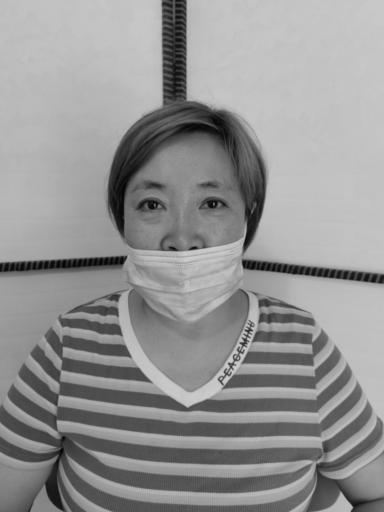

In [10]:
path = gray_df.iloc[0]["abs_path"]
img = Image.open(path)
img

# Get average mean and std of the images

In [11]:
def get_img_stats(img_paths):
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for path in img_paths:
        img = np.array(Image.open(path))
        h, w = img.shape
        img_info['heights'].append(h)
        img_info['widths'].append(w)
        img_info['means'].append(img.mean(axis=(0,1)))
        img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [12]:
img_paths = list(gray_df['abs_path'])

img_info = get_img_stats(img_paths)

mean = np.mean(img_info["means"], axis=0) / 255.
std = np.mean(img_info["stds"], axis=0) / 255.
print(f'mean is: {mean}')
print(f'std is: {std}')

mean is: 0.5323286341163697
std is: 0.23496522208770126


# Create dataset

In [61]:
class BaseDataset(data.Dataset):

    def __init__(self, transform=None):
        
        self.X = gray_df['abs_path']
        self.y = gray_df['class']
        self.transform = transform

    def set_transform(self, transform):
        
        self.transform = transform

    def __getitem__(self, index):

        image = Image.open(self.X[index])
        label = self.y[index]
        
        # 이미지를 Augmentation 시킵니다.
        image_transform = self.transform(image)
        return image_transform, label

    def __len__(self):
        return len(self.X)

### transformers (data augmentation)

In [62]:
transforms_train_gender = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize(mean, std) # normalization
])

transforms_val_gender = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

### Create dataloader

In [63]:
dataset = BaseDataset()

# train dataset과 validation dataset을 8:2 비율로 나눕니다.
n_val = int(len(dataset) * 0.2)
n_train = len(dataset) - n_val
train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])

# 각 dataset에 augmentation 함수를 설정합니다.
train_dataset.dataset.set_transform(transforms_train_gender)
val_dataset.dataset.set_transform(transforms_val_gender)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_dataset))
print('Validation dataset size:', len(val_dataset))

Train dataset size: 15120
Validation dataset size: 3779


### Convert to GPU

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device object
device

device(type='cuda', index=0)

## Download pretrained model and change the layer to input grayscaled images

In [65]:
class MnistResNet(nn.Module):
    def __init__(self, in_channels=1):
        super(MnistResNet, self).__init__()

        # Load a pretrained resnet model from torchvision.models in Pytorch
        self.model = models.resnext50_32x4d(pretrained=True)

        # Change the input layer to take Grayscale image, instead of RGB images. 
        # Hence in_channels is set as 1 or 3 respectively
        # original definition of the first layer on the ResNet class
        # self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Change the output layer to output 10 classes instead of 1000 classes
        num_ftrs = self.model.fc.in_features
        self.model.fc = nn.Linear(num_ftrs, 18)

    def forward(self, x):
        return self.model(x)

In [66]:
model = MnistResNet()
model.to(bdevice)

MnistResNet(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seq

### Loss function and optimizer

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Training phase

In [69]:
num_epochs = 3
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Validation Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(val_dataset)
        epoch_acc = running_corrects / len(val_dataset) * 100.
        print('[Validation #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

[Train #0] Loss: 0.0286 Acc: 99.6164% Time: 60.6928s
[Validation #0] Loss: 0.2012 Acc: 93.4109% Time: 65.8693s
[Train #1] Loss: 0.0207 Acc: 99.7156% Time: 126.6831s
[Validation #1] Loss: 0.2028 Acc: 93.1199% Time: 131.8553s
[Train #2] Loss: 0.0140 Acc: 99.8942% Time: 192.6996s
[Validation #2] Loss: 0.2171 Acc: 93.1463% Time: 197.8442s


# Test the model

In [32]:
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize, ToTensor, Normalize

In [45]:
test_dir = '/opt/ml/input/data/eval'
test_image_dir = f'{test_dir}/images'
test_gray_image_dir = f'{test_dir}/gray_images'

### Test dataset

### convert test dataset into grayscale

In [46]:
test_images = os.listdir(os.path.join(test_dir, 'images'))
test_images = [path for path in test_images if path[0] != '.']
test_images[:5]

['9c8457c2f97279d3c1fd40a156107b1bf31977d7.jpg',
 '8982314b756f8efd277e344807b0e816534e9715.jpg',
 '6385b2001b9a507cd57dc0990afefab89176afef.jpg',
 'bce96db4ff3c5eaae1c530c458ba91095d3b5b92.jpg',
 'e9cfdf889c4f7d9fa8679af660e348cc1971ae3b.jpg']

In [48]:
for path in test_images:
    path = os.path.join(test_image_dir, path)
    img = Image.open(path).convert('L')
    file_name = path[31:]
    img.save(os.path.join(test_gray_image_dir, file_name))

In [35]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [70]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))

# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(test_gray_image_dir, img_id) for img_id in submission.ImageID]
transform = transforms.Compose([
    Resize((224, 224), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=mean, std=std),
])

dataset = TestDataset(image_paths, transform)

loader = DataLoader(
    dataset,
    shuffle=False
)

In [71]:
def imshow(input, title):
    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    # undo image normalization
    input = std * input + mean
    input = np.clip(input, 0, 1)
    # display images
    plt.imshow(input)
    plt.title(title)
    plt.show()

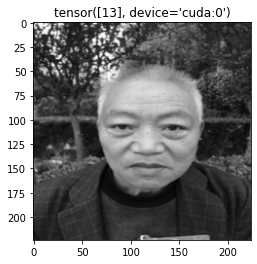

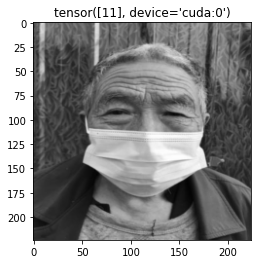

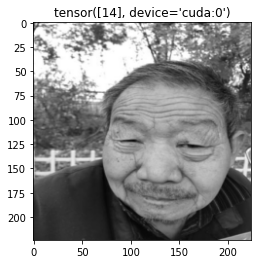

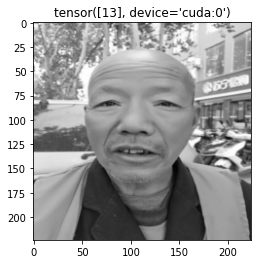

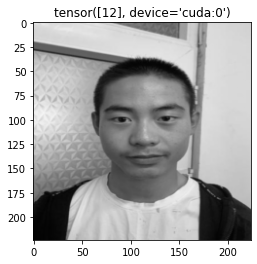

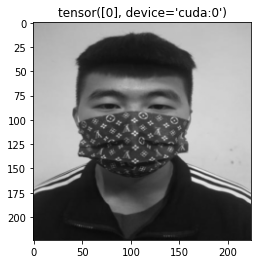

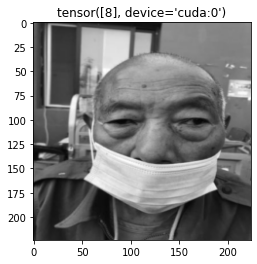

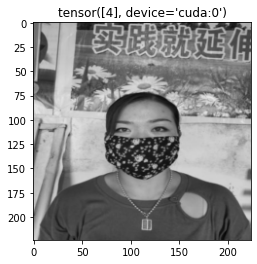

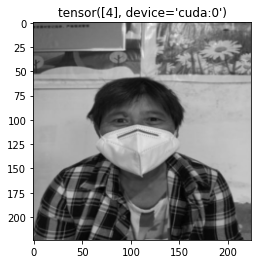

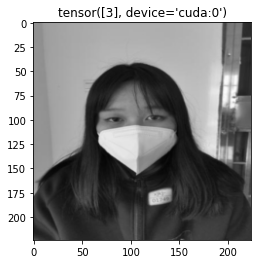

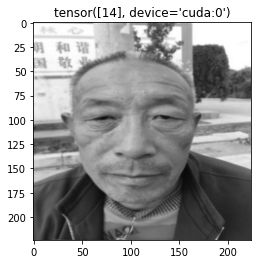

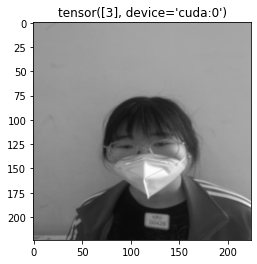

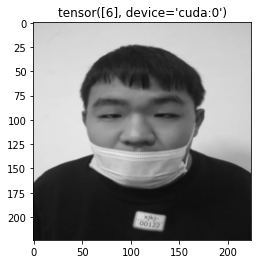

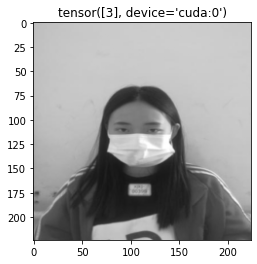

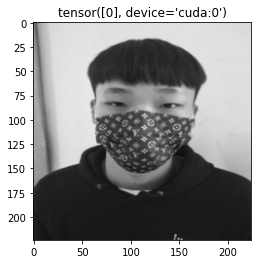

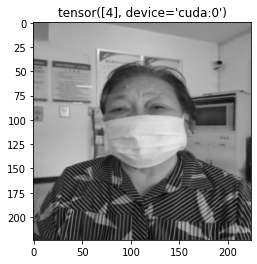

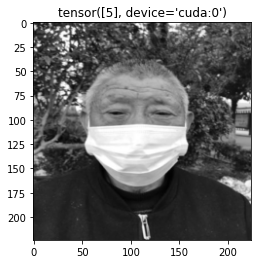

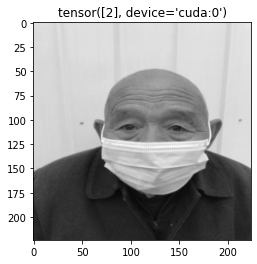

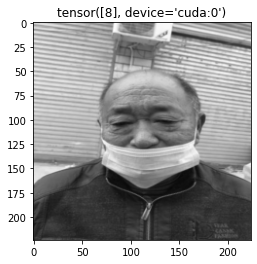

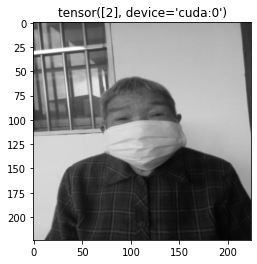

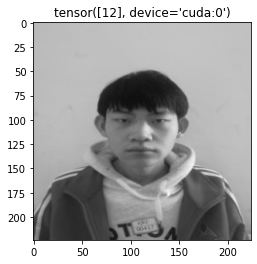

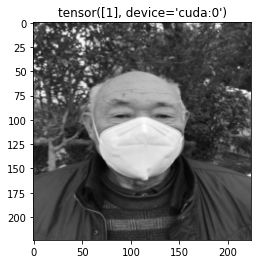

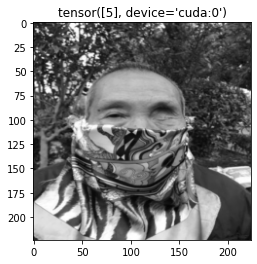

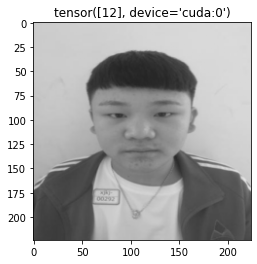

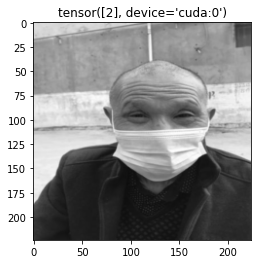

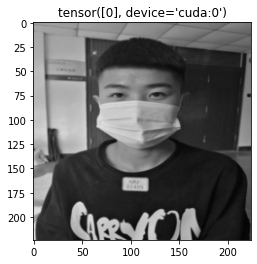

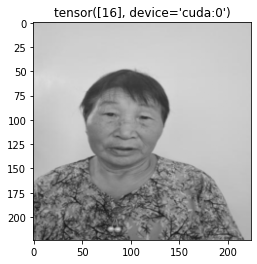

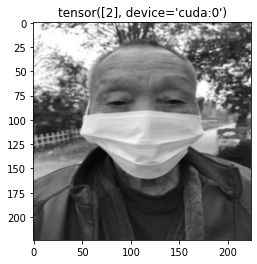

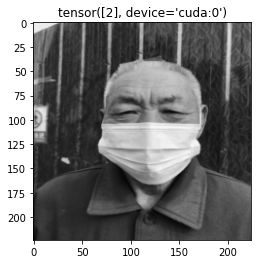

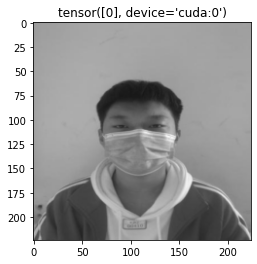

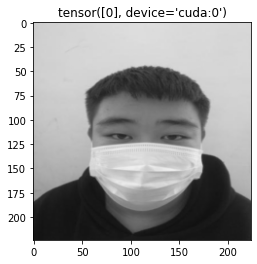

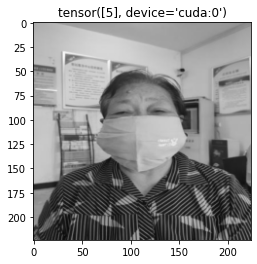

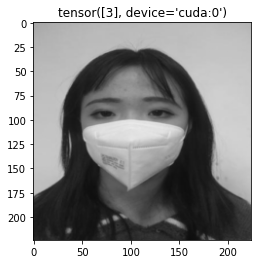

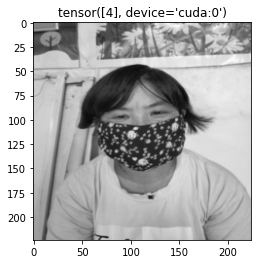

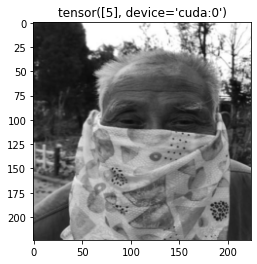

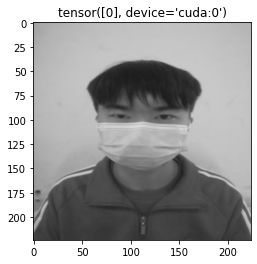

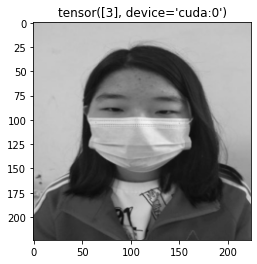

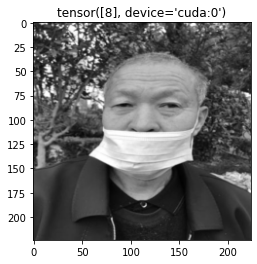

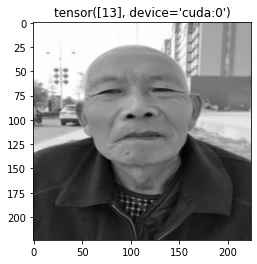

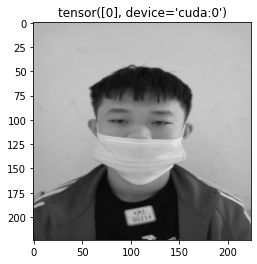

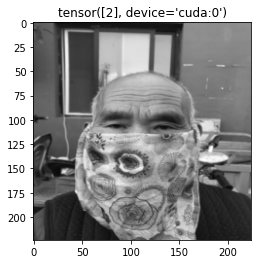

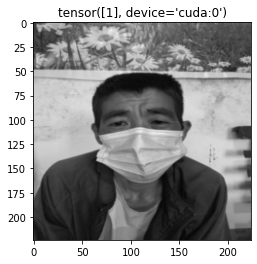

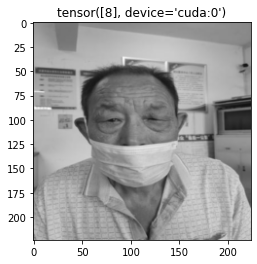

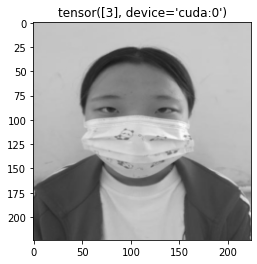

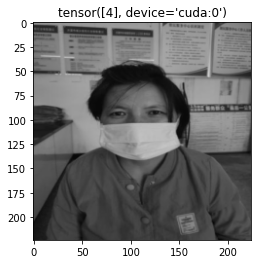

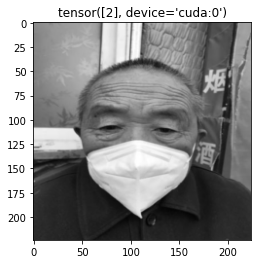

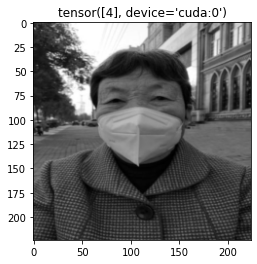

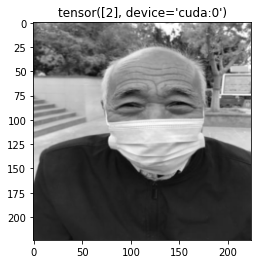

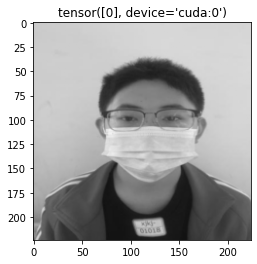

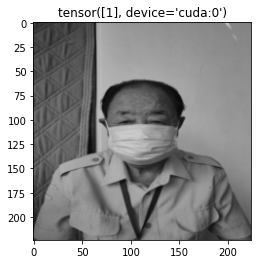

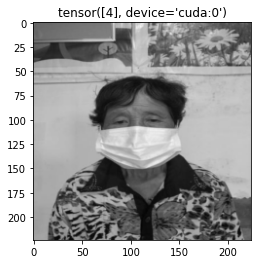

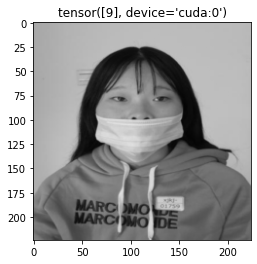

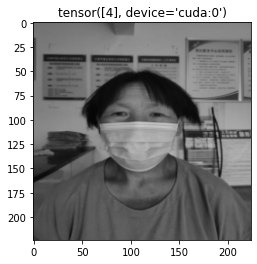

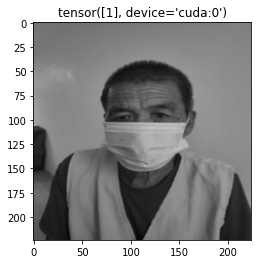

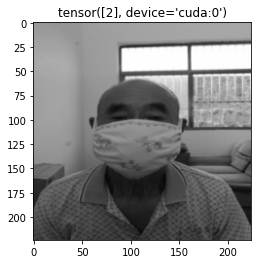

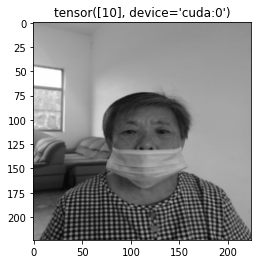

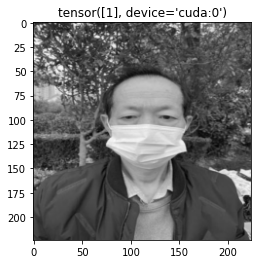

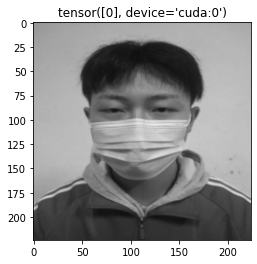

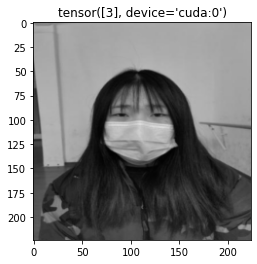

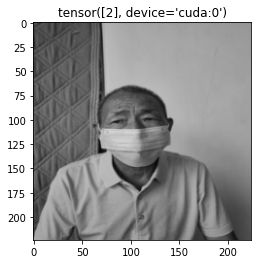

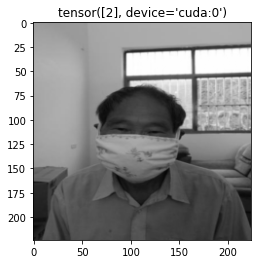

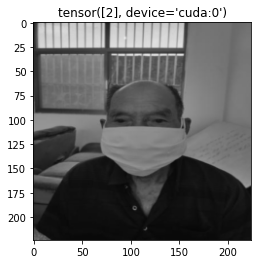

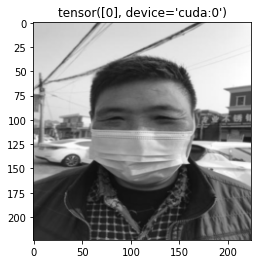

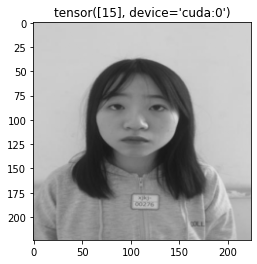

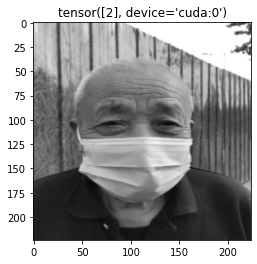

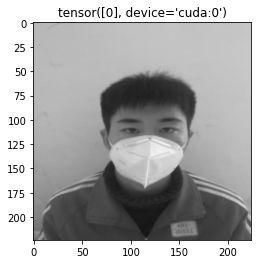

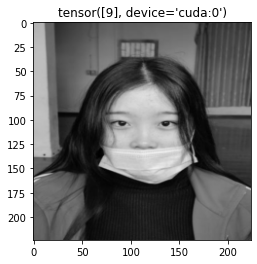

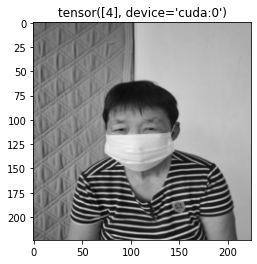

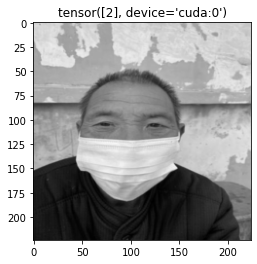

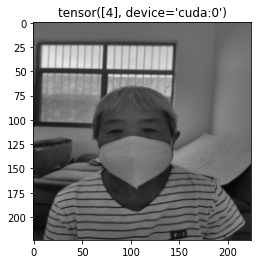

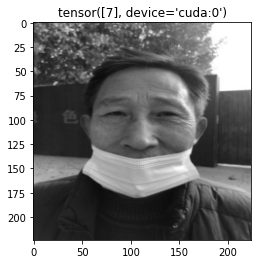

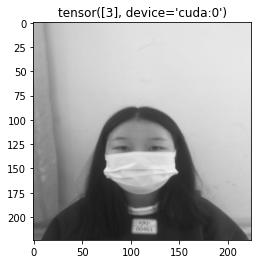

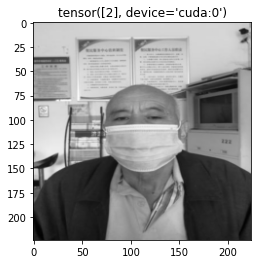

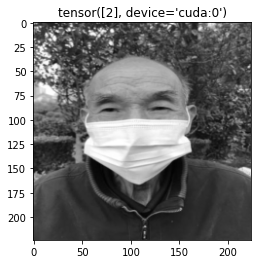

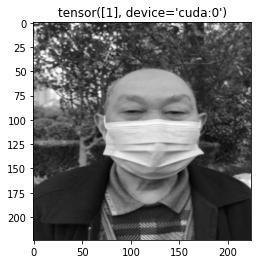

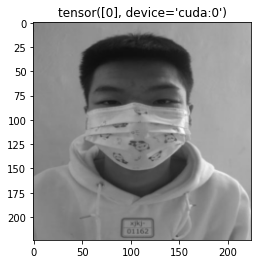

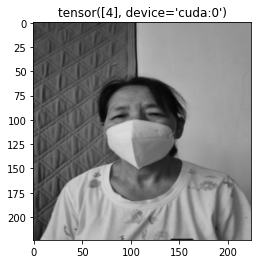

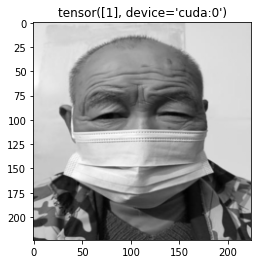

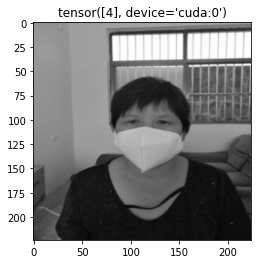

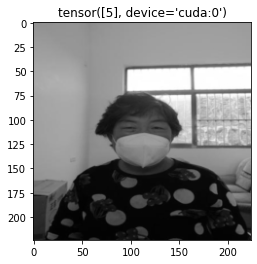

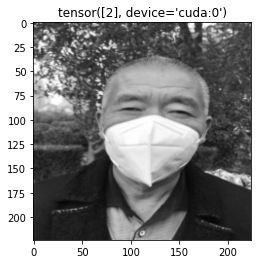

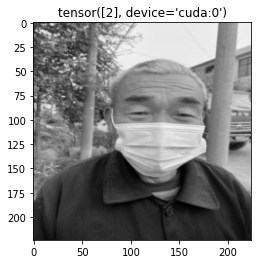

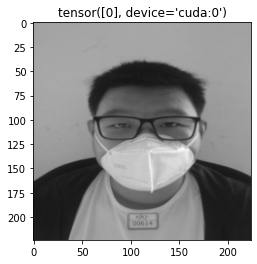

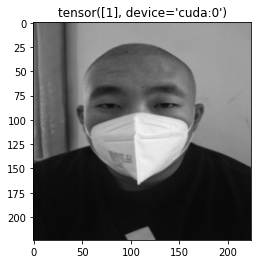

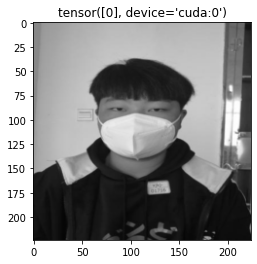

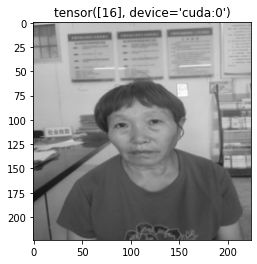

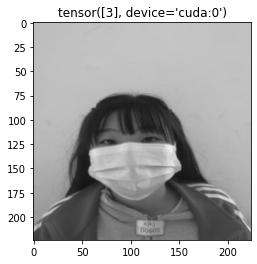

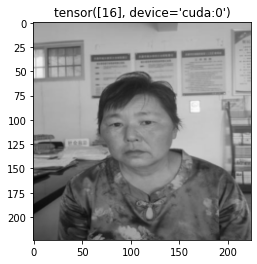

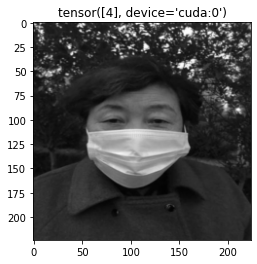

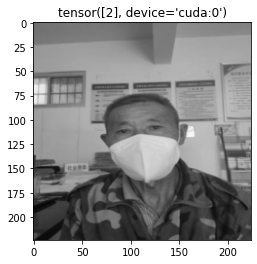

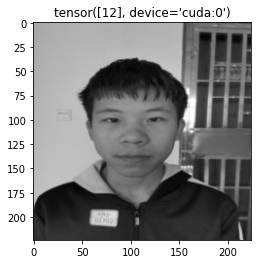

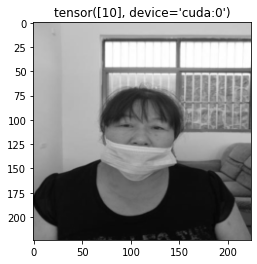

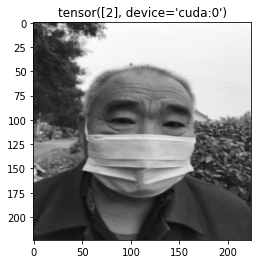

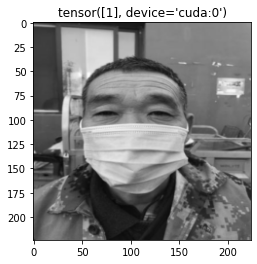

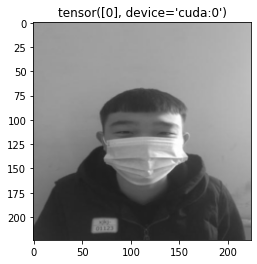

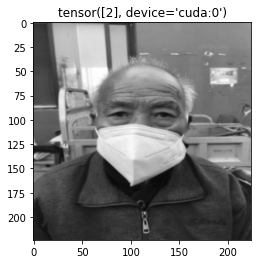

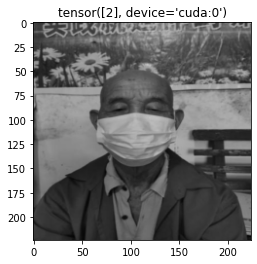

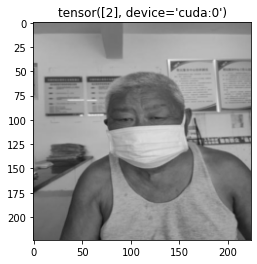

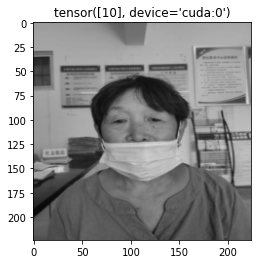

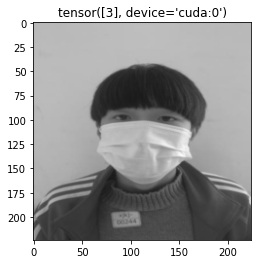

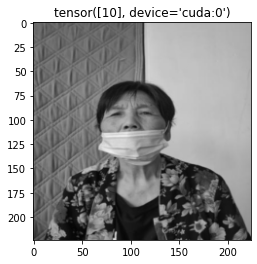

In [72]:
import torchvision

# Test gender model
model.eval()
start_time = time.time()
class_names = [0, 1]

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, inputs in enumerate(loader):
        inputs = inputs.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        images = torchvision.utils.make_grid(inputs)
        imshow(images.cpu(), title=preds)
        
#         if i == 0:
#             print('[Prediction Result Examples]')
#             images = torchvision.utils.make_grid(inputs[:4])
#             imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
#             images = torchvision.utils.make_grid(inputs[4:8])
#             imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            
        if i == 100:
            break

# Make final predictions

In [73]:
# combined model
model.eval()
all_predictions= []
for images in loader:
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predicted = predicted.cpu().numpy()
        all_predictions.append(predicted)
        print(predicted)

[13]
[11]
[14]
[13]
[12]
[0]
[8]
[4]
[4]
[3]
[14]
[3]
[6]
[3]
[0]
[4]
[5]
[2]
[8]
[2]
[12]
[1]
[5]
[12]
[2]
[0]
[16]
[2]
[2]
[0]
[0]
[5]
[3]
[4]
[5]
[0]
[3]
[8]
[13]
[0]
[2]
[1]
[8]
[3]
[4]
[2]
[4]
[2]
[0]
[1]
[4]
[9]
[4]
[1]
[2]
[10]
[1]
[0]
[3]
[2]
[2]
[2]
[0]
[15]
[2]
[0]
[9]
[4]
[2]
[4]
[7]
[3]
[2]
[2]
[1]
[0]
[4]
[1]
[4]
[5]
[2]
[2]
[0]
[1]
[0]
[16]
[3]
[16]
[4]
[2]
[12]
[10]
[2]
[1]
[0]
[2]
[2]
[2]
[10]
[3]
[10]
[2]
[2]
[2]
[0]
[3]
[1]
[12]
[4]
[4]
[0]
[16]
[0]
[0]
[4]
[13]
[10]
[5]
[3]
[3]
[3]
[9]
[11]
[5]
[15]
[1]
[2]
[14]
[0]
[13]
[4]
[0]
[7]
[3]
[3]
[13]
[2]
[14]
[0]
[15]
[2]
[5]
[3]
[0]
[0]
[1]
[9]
[4]
[0]
[2]
[1]
[4]
[4]
[12]
[13]
[16]
[3]
[0]
[15]
[16]
[3]
[15]
[5]
[8]
[0]
[4]
[13]
[3]
[1]
[1]
[4]
[14]
[1]
[7]
[7]
[3]
[3]
[2]
[3]
[4]
[2]
[0]
[2]
[17]
[6]
[0]
[2]
[9]
[16]
[17]
[4]
[13]
[0]
[4]
[0]
[12]
[3]
[14]
[12]
[6]
[4]
[0]
[0]
[12]
[2]
[3]
[11]
[4]
[0]
[4]
[16]
[3]
[1]
[6]
[3]
[4]
[8]
[2]
[3]
[0]
[13]
[13]
[2]
[3]
[0]
[2]
[5]
[4]
[0]
[3]
[1]
[13]
[14]
[0]
[8]
[3]
[1]
[

In [74]:
for i in range(len(all_predictions)):
    all_predictions[i] = int(all_predictions[i])

print(all_predictions[:5])
print(len(all_predictions))

[13, 11, 14, 13, 12]
12600


In [75]:
submission['ans'] = all_predictions

# 제출할 파일을 저장합니다.
submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
